# Logistic Regression on Car Insurance Data
## Goal:  To predict whether or not client has subscribed to Car Insurance
### 3 Methods:  'Vanilla Logistic Regression', Ridge Regression, Lasso Regression

We have Car Insurance Cold Call data and our goal is to predict whether or not someone will buy car insurance.

### Load in Data and Take a Look

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Read-in train and test datasets
datatrain = pd.read_csv('carInsurance_train.csv')
datatest = pd.read_csv('carInsurance_test.csv')

train = pd.DataFrame(datatrain)
test = pd.DataFrame(datatest)

In [3]:
# Take a peek at the data
print('The training set has {} columns and {} observations\n'. format(train.shape[1], train.shape[0]))
print('The testing set has {} columns and {} observations\n'. format(test.shape[1], test.shape[0]))
print(train.info())
print('')
print(train.describe(include='all'))

# Note that the data came with a training and testing set

The training set has 19 columns and 4000 observations

The testing set has 19 columns and 1000 observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
Id                  4000 non-null int64
Age                 4000 non-null int64
Job                 3981 non-null object
Marital             4000 non-null object
Education           3831 non-null object
Default             4000 non-null int64
Balance             4000 non-null int64
HHInsurance         4000 non-null int64
CarLoan             4000 non-null int64
Communication       3098 non-null object
LastContactDay      4000 non-null int64
LastContactMonth    4000 non-null object
NoOfContacts        4000 non-null int64
DaysPassed          4000 non-null int64
PrevAttempts        4000 non-null int64
Outcome             958 non-null object
CallStart           4000 non-null object
CallEnd             4000 non-null object
CarInsurance        4000 non-null int64
dtypes: int64(11)

With the exception of the outcome independent variable, almost all of the training data is non null.  Since we are selecting the car insurance variable as the desired outcome we have 10 numeric independent variables and 8 categorical.  It also appears that of the 10 numeric variables 3 are binary.  The ID column is not very useful because it is essentially representing an index of all the clients we will drop this variable moving forward. 

Before we start let's fix some of the missing values.

### Missing Data

In [4]:
# Combine train and test to clean data all at once
all_df = pd.concat([train, test]).copy()

# Drop the Id column
all_df.drop('Id',1,inplace=True)

# Replace missing in communication column with none
all_df['Communication'].fillna('none', inplace=True)

# Let's see if we can impute the missing education based on the most common education job type
# Get job types
job_types = all_df['Job'].dropna().unique().tolist()
#print(job_types)

# Find most common education level for each job type
edujob = {}
for job in job_types:
    edu = all_df[all_df['Job']==job]['Education'].value_counts().argmax()
    edujob[job] = edu

edujobmap = pd.Series(edujob)

# Map most common edu level for each job type to missing education for that job type
for job in job_types:
    all_df.loc[(all_df['Education'].isnull()) & (all_df['Job']==job), 'Education'] = edujobmap[job]

# We were able to fix all but 11 of the missing values in the education column
# For the rest we will set them to none

#print(all_df['Education'].isnull().sum())
all_df['Education'].fillna('none', inplace=True)
    
# Tried to do this before the mapping for the education missing but argmax didn't work on the NaN value
all_df['Job'].fillna('none', inplace=True)

print(all_df.isnull().sum())

Age                    0
Job                    0
Marital                0
Education              0
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication          0
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3799
CallStart              0
CallEnd                0
CarInsurance        1000
dtype: int64


The outcome column represents the outcome of the previous marketing campaign, whether is was a success or a failure.  The Days Passed column has a -1 value for all of the members that were not previously contacted during the previous campaign.

In [5]:
print(all_df.Outcome.value_counts(dropna=False))
print(all_df.DaysPassed.value_counts()[:1])

# We can see that the -1 values for the Days Passed tie to the missing values for the Outcome variable
all_df.loc[all_df['DaysPassed']==-1,'Outcome']='none'
print('')
print(all_df.isnull().sum())

NaN        3799
failure     548
success     405
other       248
Name: Outcome, dtype: int64
-1    3799
Name: DaysPassed, dtype: int64

Age                    0
Job                    0
Marital                0
Education              0
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication          0
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome                0
CallStart              0
CallEnd                0
CarInsurance        1000
dtype: int64


In [6]:
# Now let's address the date time variables - Call Start and Call End

# Convert to DateTime
all_df['CallStart'] = pd.to_datetime(all_df['CallStart'])
all_df['CallEnd'] = pd.to_datetime(all_df['CallEnd'])

# Get Call length in second
all_df['CallLength'] = ((all_df['CallEnd'] - all_df['CallStart'])/np.timedelta64(1,'s'))

# Now that we have the call length in seconds let's drop the call start and call end
all_df.drop(['CallStart', 'CallEnd'], 1, inplace=True)

Now that we have handled all of the missing values and the datetime variables, let's break back up into training and test sets and begin looking at the 8 categorical variables first.

### Visualization 

In [7]:
# re-create the training and test data
training = all_df.iloc[train.index,:]
testing = all_df.iloc[test.index,:]
print(training.shape)
print(testing.shape)

(4000, 17)
(1000, 17)


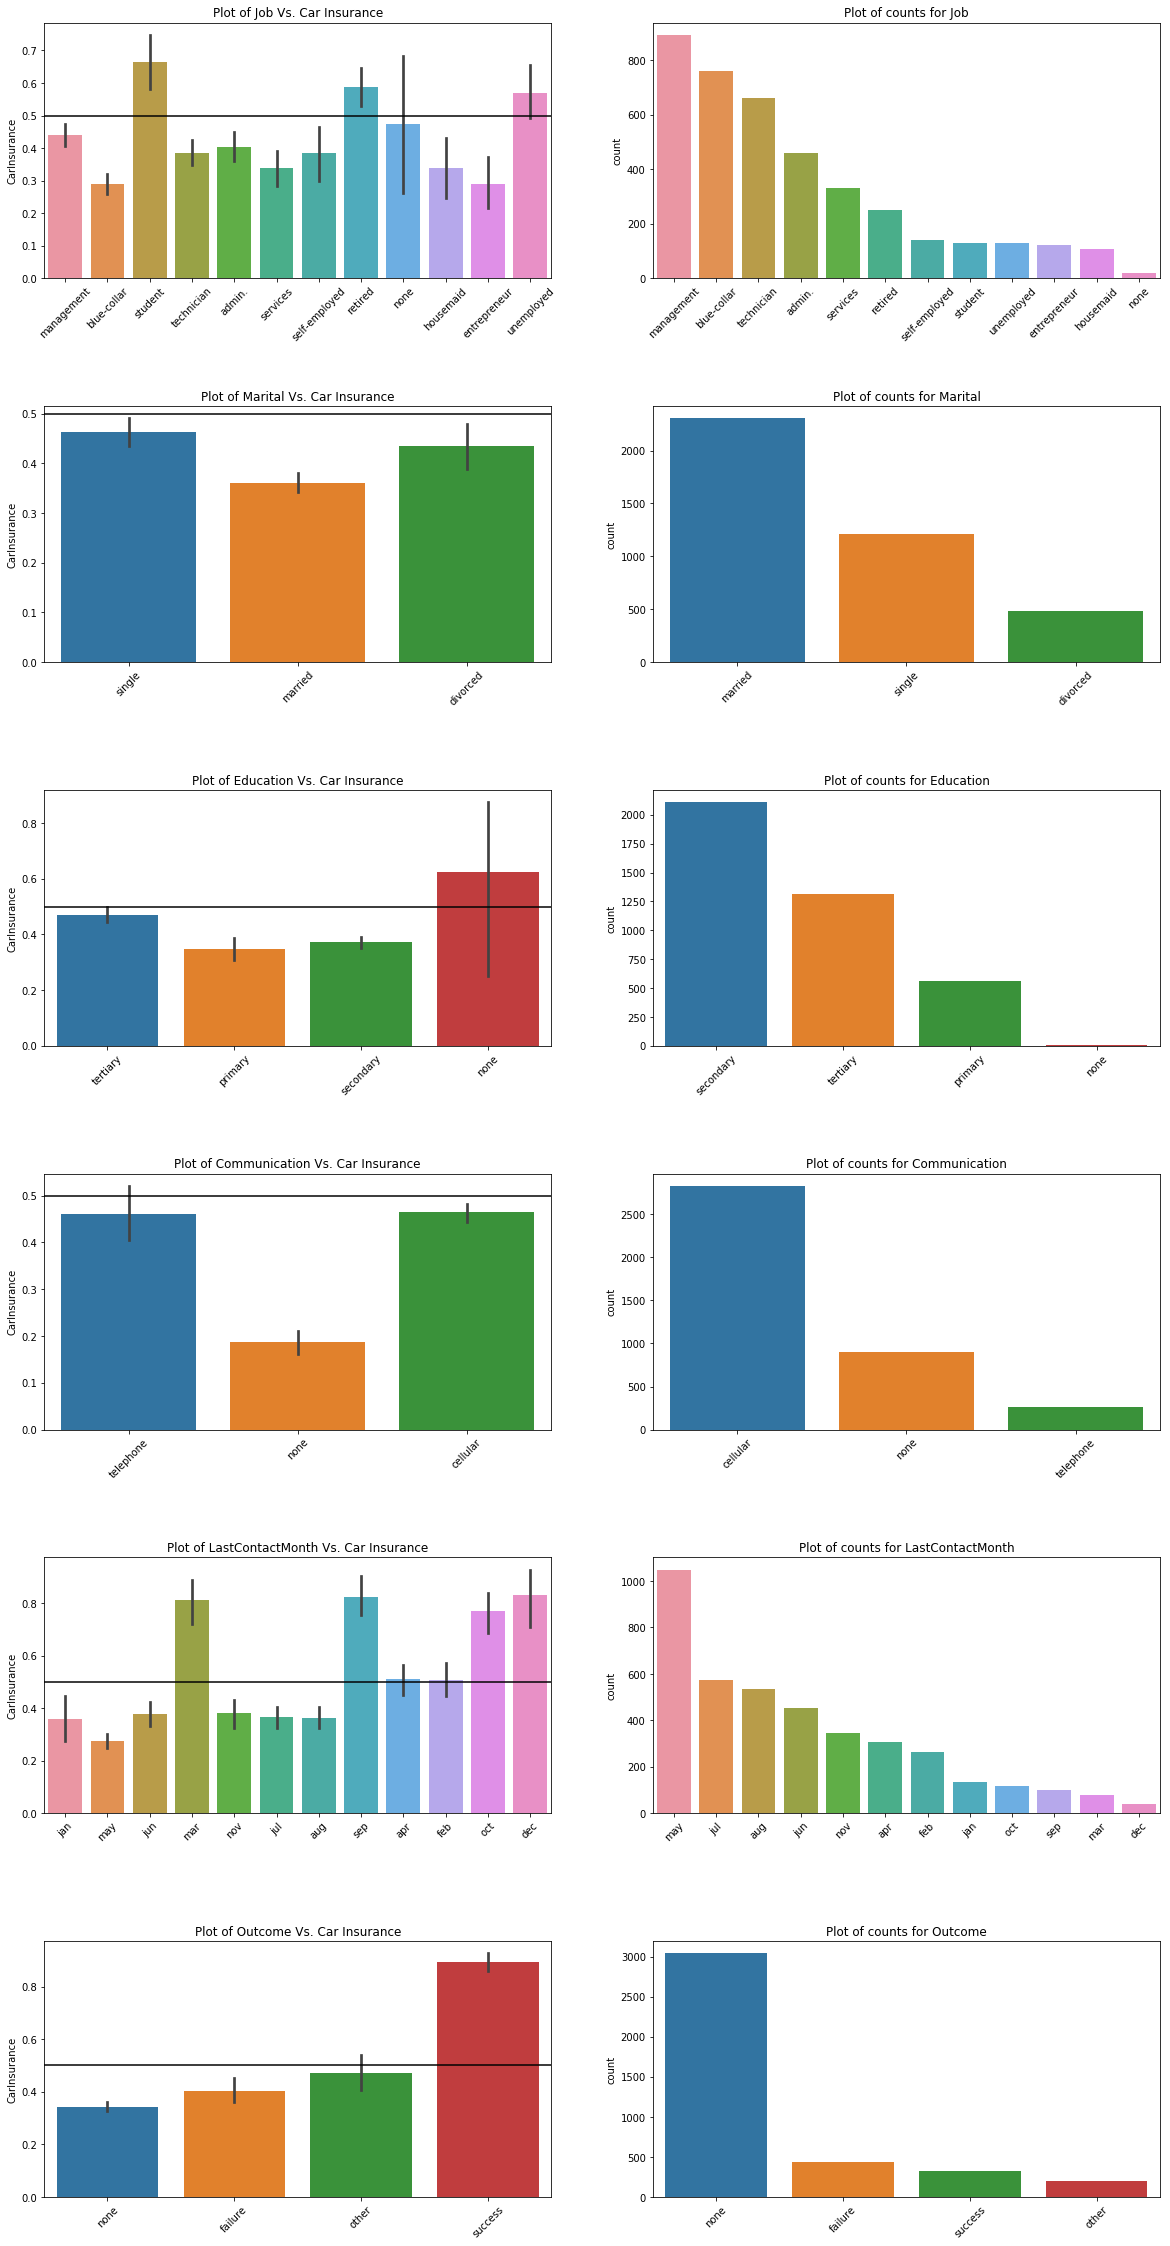

In [8]:
cat_df = training.select_dtypes(include=['object'])
#cats_to_explore = cat_df.drop(["CallStart", "CallEnd"], axis=1)

fig = plt.figure(1, figsize=(20, 40))
fig.subplots_adjust(hspace = .5)
numplt = 0
for cat in cat_df.columns:

    numplt += 1
    ax = fig.add_subplot(6, 2, numplt)
    sns.barplot(x=cat_df[cat], y=training['CarInsurance'], ax=ax)
    plt.title('Plot of '+str(cat)+' Vs. Car Insurance')
    plt.axhline(y=0.5, color='k')
    plt.xlabel(None)
    plt.xticks(rotation=45)
    
    numplt += 1
    ax = fig.add_subplot(6, 2, numplt)
    sns.countplot(x=cat, data=training, order=training[cat].value_counts().index, ax=ax)
    plt.title('Plot of counts for '+ str(cat))
    plt.xlabel(None)
    plt.xticks(rotation=45)

**Job:** The students are the most likely to buy car insurance.  The two other job titles most likely to buy car insurance are retired folks and unemployed.  
**Marital:** Married people are the least likely to buy car insurance.  
**Education:** The more educated the more likely you are to buy car insurance.  
**Communication:** Telephone and cellular communication are pretty even.  Cellular communication has a slightly smaller error bar.  
**Last Contact Month:** The contact from the months of Dec, Sept, Mar, and Oct is showing the highest likelihood of buying car insurance.  
**Outcome:**  As expected, the success of the previous campaign correlates with a higher likelihood to buy car insurance.

Look at numeric independent variables now.

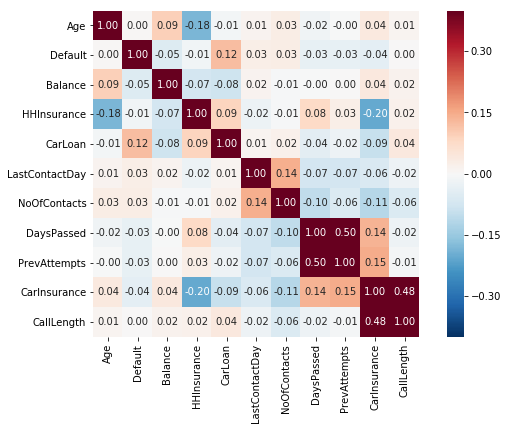

In [9]:
num_df = training.select_dtypes(exclude=['object'])

# let's first look at some correlations
corr = num_df.corr()

fig = plt.figure(figsize=(10,6))
sns.heatmap(corr, vmin=-0.4, vmax=0.4, square=True, annot=True, fmt='0.2f', cmap='RdBu_r')
plt.show()



We have very little correlation between variables in our data, with the exception of Previous Attempts and Days Passed and Call Length and Car Insurance.  Let's now look at some of the relationships between the continuous variables.

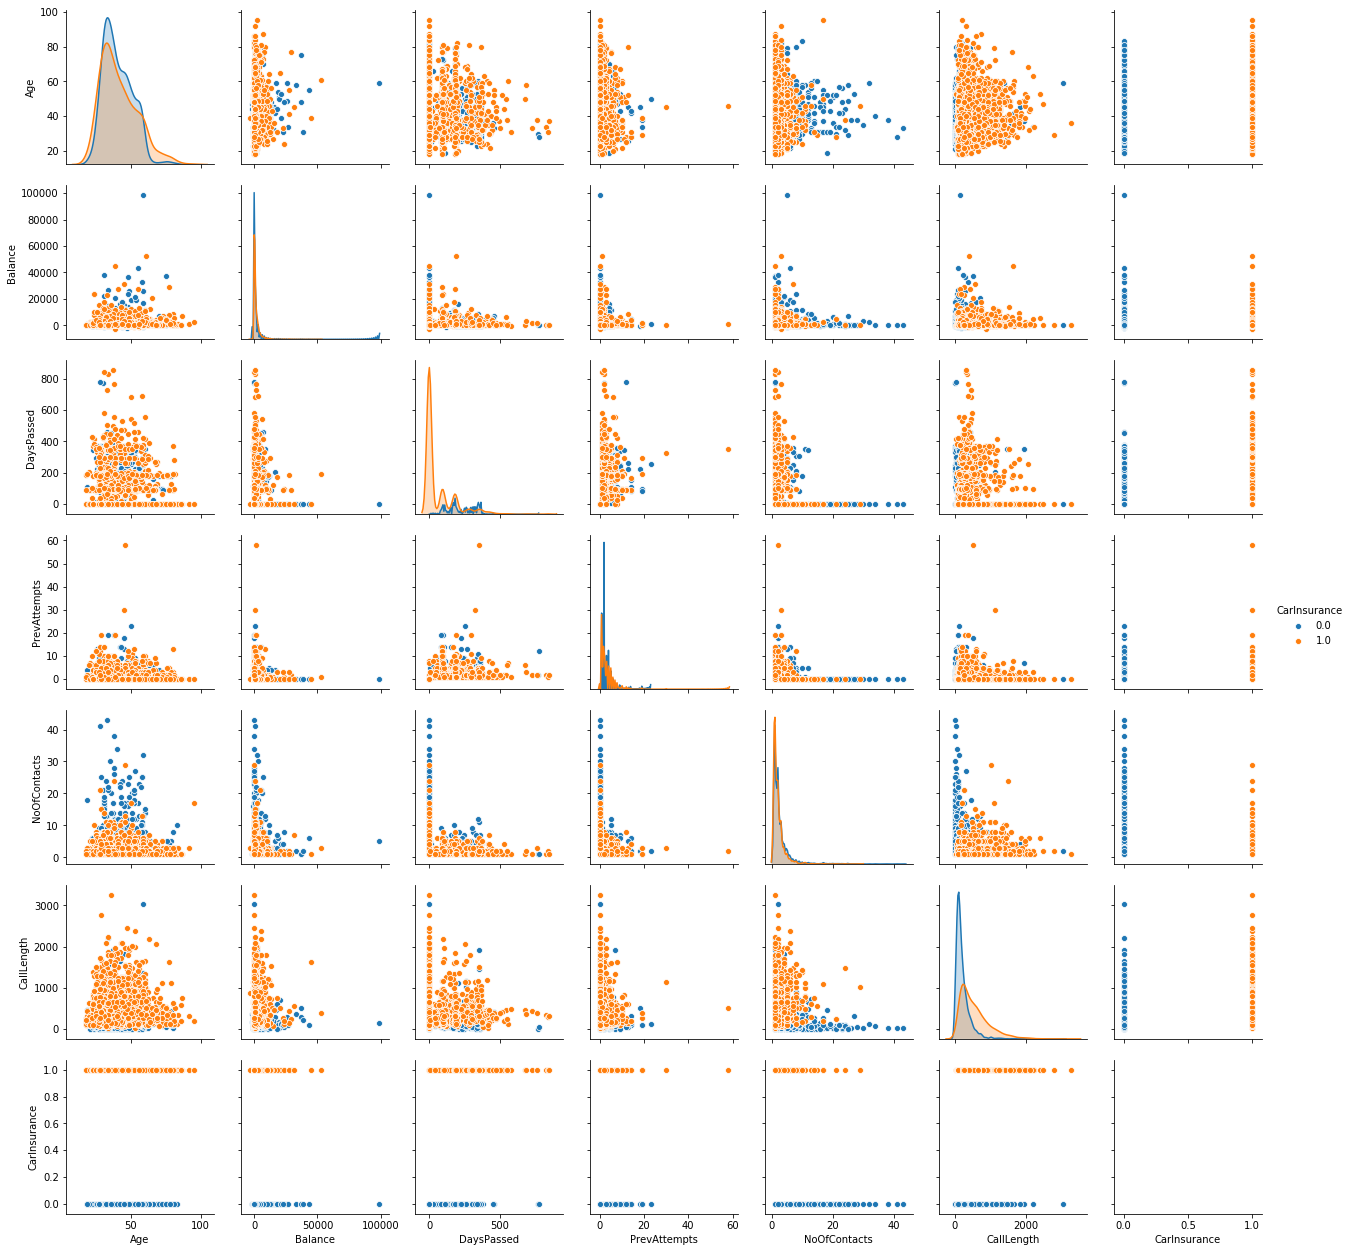

In [10]:
cont_df = num_df[['Age', 'Balance', 'DaysPassed', 'PrevAttempts', 'NoOfContacts', 'CallLength', 'CarInsurance']]

# Pairplot
g = sns.pairplot(cont_df, hue='CarInsurance', diag_kind='kde')

From the plots above we can see that there may be an outlier in the balance and previous attempts columns.

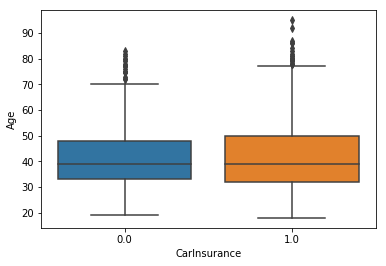

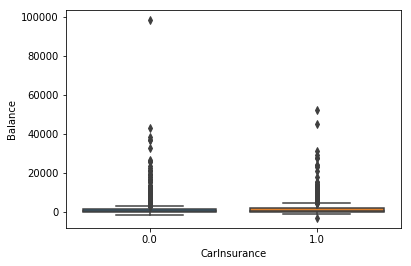

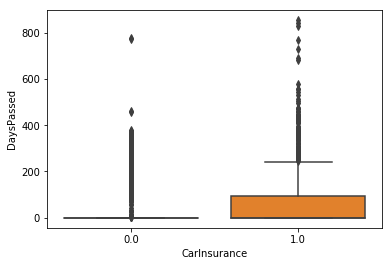

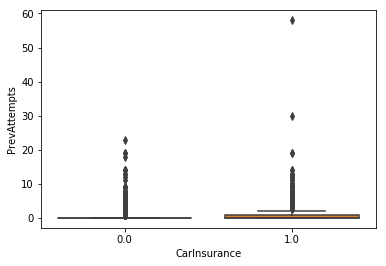

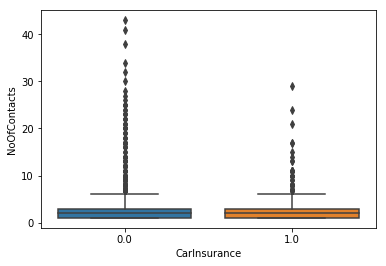

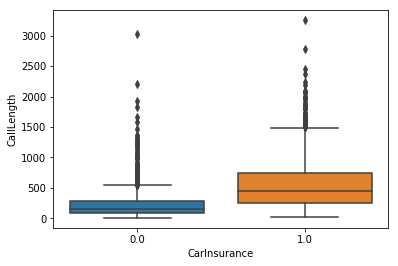

In [11]:
# boxplots
for col in cont_df.columns:
    if col == 'CarInsurance':
        continue
    sns.boxplot(x='CarInsurance', y=col, data=cont_df)
    plt.show()
# not sure why the hue is not working - I think it is because I need the x and y both set to show hue

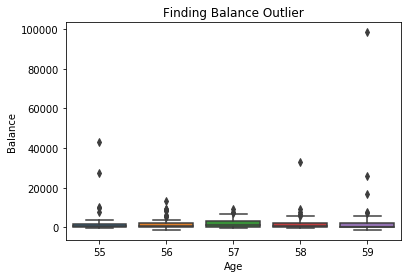

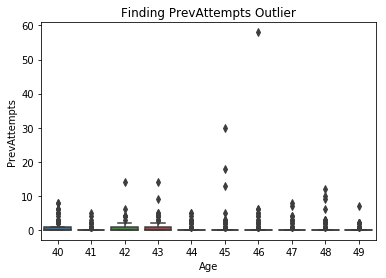

In [12]:
findoutlier = cont_df[cont_df['Age'].isin(range(55,60))]["Age"]   
sns.boxplot(x=findoutlier, y='Balance', data=cont_df)
plt.title('Finding Balance Outlier')
plt.show()

findoutlier1 = cont_df[cont_df['Age'].isin(range(40,50))]["Age"]
sns.boxplot(x=findoutlier1, y=cont_df.PrevAttempts)
plt.title('Finding PrevAttempts Outlier')
plt.show()

We can see that the outlier in the balance is associated with a 59 yr old and the PrevAttempts outlier is associated with a 46 yr old.  Since our data set is so large it should be fine to drop those two values.

In [13]:
# Find the index of the balance and PrevAttempts outliers
badbal = training.Balance.argmax()
badattempt = training.PrevAttempts.argmax()

# Drop the two outliers
training.drop([badbal, badattempt],axis=0, inplace=True)

# get dummies for the categorical variables
training = pd.get_dummies(training)  
testing = pd.get_dummies(testing)
print(training.shape)
print(testing.shape)

(3998, 49)
(1000, 49)


### Simple Model for a Baseline

In [18]:
# create a simple Logistic Regression Function
def simple_log_reg(x,y,c=1):
    lr = LogisticRegression(C=c)
    y = y
    X = x

    # Fit the model.
    fit = lr.fit(X, y)

    # Display.
    print('Coefficients')
    print(fit.coef_)
    print('\nIntercept')
    print(fit.intercept_)
    
    # Predict the model
    pred_y_logreg = lr.predict(X)

    print('\nAccuracy by Car Insurance status')
    print(pd.crosstab(y, pred_y_logreg))

    print('\nPercentage accuracy')
    print(lr.score(X, y))
    return

def simple_ridge_reg(x, y, alpha):
    # Initiate model
    ridgereg = Ridge(alpha=alpha)

    # Set variables
    y=y
    X=x
    
    # Fit the model
    fit = ridgereg.fit(X, y)
    
    # Display the coefficients
    print('Coefficients')
    print(fit.coef_)
    print('\nIntercept')
    print(fit.intercept_)
    
    # Predict model
    pred_y_ridge = ridgereg.predict(X)
    
    # Confusion matrix
    #print('\nAccuracy by Car Insurance status')
    #print(confusion_matrix(y, pred_y_ridge))
       
    print('\nPercentage accuracy')
    print(ridgereg.score(X, y))
    return

def simple_lasso_reg(x, y, alpha):
    # Initiate model
    lassoreg = Lasso(alpha=alpha)

    # Set variables
    y=y
    X=x
    
    # Fit the model
    fit = lassoreg.fit(X, y)
    
    # Display the coefficients
    print('Coefficients')
    print(fit.coef_)
    print('\nIntercept')
    print(fit.intercept_)
    
    # Predict model
    pred_y_lasso = lassoreg.predict(X)

    # Confusion matrix
    #print('\nAccuracy by Car Insurance status')
    #print(confusion_matrix(y, pred_y_lasso))
    
    print('\nPercentage accuracy')
    print(lassoreg.score(X, y))
    return

In [19]:
# Find the total number of 1 and 0 for car insurance training set
print('Total Clients Subscribed to Car Insurance in Training Set')
print(training.CarInsurance.value_counts())
print('')

simple_log_reg(training.drop('CarInsurance', 1), training.CarInsurance, 1e9)

Total Clients Subscribed to Car Insurance in Training Set
0.0    2395
1.0    1603
Name: CarInsurance, dtype: int64

Coefficients
[[ 8.70965537e-04 -3.67222624e-01 -6.96227225e-06 -8.26811947e-01
  -5.97690007e-01  1.17796714e-03 -7.00965367e-02  5.29183283e-04
   3.30666233e-02  5.95277228e-03  2.70370128e-01 -2.70213890e-01
  -5.44986384e-01 -2.24165274e-01 -1.64938919e-01 -1.06581477e+00
   4.61434095e-01 -2.75506915e-01  4.95282308e-02  8.71595837e-01
   7.74768691e-02  4.08278933e-01 -1.19630520e-01 -2.85208942e-01
  -2.10259757e-03  1.05104095e+00 -6.35405675e-01 -6.40626136e-01
  -1.81951202e-01  3.86970800e-01 -1.28849794e+00  4.94585080e-01
  -6.48377373e-02 -1.06233935e+00  7.66089846e-01 -1.22476321e-01
  -1.61853363e+00 -8.99931392e-01  4.41990032e-01  1.36061795e+00
  -5.90357678e-01 -7.95616478e-01  1.12579633e+00  1.05265638e+00
  -7.25215856e-01 -7.31436458e-01 -6.87409054e-01  1.73711931e+00]]

Intercept
[-0.40694206]

Accuracy by Car Insurance status
col_0          0.0

In [20]:
# Find the total number of 1 and 0 for car insurance testing set
print('Total Clients Subscribed to Car Insurance in Testing Set')
print(testing.CarInsurance.value_counts())
print('')

simple_log_reg(testing.drop('CarInsurance', 1), testing.CarInsurance, 1e9)

Total Clients Subscribed to Car Insurance in Testing Set
0.0    584
1.0    416
Name: CarInsurance, dtype: int64

Coefficients
[[ 9.03547392e-03 -7.82081053e-01 -3.17323052e-05 -1.19914123e+00
  -6.69747744e-01  6.48441967e-04 -6.90808399e-02  1.64565696e-03
   1.31267465e-01  6.94878147e-03  4.78011132e-01 -1.39319099e-01
  -1.27212762e-01  1.17624736e-01 -1.50808971e-01 -2.67159532e+00
   5.72118307e-01  2.01160223e-01  1.59524683e-01  5.55078396e-01
  -1.68852033e-01  3.06388974e-01 -4.39470046e-01 -4.68043205e-01
   3.96315137e-02  1.32428935e+00 -6.42332987e-01 -1.09631254e+00
  -4.53525562e-01  5.46042871e-01 -1.29135089e+00 -1.22573720e-01
   1.04060477e-01 -1.49849340e+00  9.52556593e-01 -4.38638236e-01
  -1.13944375e+00 -7.36840069e-01  2.69786470e-01  4.85592824e-01
  -4.65334830e-01 -6.82050359e-01  9.30526116e-01  1.35039642e+00
  -6.95224567e-01 -2.10661048e-01 -1.24606107e+00  1.28406495e+00]]

Intercept
[-0.86788174]

Accuracy by Car Insurance status
col_0         0.0  1.

In [21]:
simple_ridge_reg(training.drop('CarInsurance', 1), training.CarInsurance, 1)

Coefficients
[ 2.27797988e-04 -3.73776373e-02 -4.05231506e-08 -1.15081530e-01
 -6.95884758e-02  9.78547032e-05 -5.36639285e-03  9.64583858e-05
  3.98774538e-03  6.97927302e-04  3.61846050e-02 -2.66308961e-02
 -7.54334521e-02 -4.26382158e-02 -2.99693167e-02 -9.19472229e-02
  6.74258346e-02 -4.99754016e-02 -1.70176014e-03  1.66709073e-01
  9.48356937e-04  4.70283954e-02  7.61303648e-03 -2.17424270e-02
  1.41293905e-02  1.28441133e-01 -6.72356569e-02 -6.38708880e-02
  2.66541228e-03  7.57511004e-02 -1.31417771e-01  5.56666704e-02
  7.36726214e-03 -1.58780228e-01  1.17256602e-01 -3.62115599e-02
 -2.33587589e-01 -1.19192540e-01  4.53465560e-02  2.56807006e-01
 -6.46836440e-02 -1.19327426e-01  1.64161860e-01  1.40843700e-01
 -9.68307996e-02 -8.67494423e-02 -8.12501942e-02  2.64830436e-01]

Intercept
0.35626418986787195

Percentage accuracy
0.4362262556593811


In [22]:
simple_ridge_reg(testing.drop('CarInsurance', 1), testing.CarInsurance, 1)

Coefficients
[ 1.54843084e-03 -3.96363855e-02 -3.48875347e-06 -1.48414357e-01
 -7.27073180e-02  4.11019879e-04 -6.48528242e-03  2.21573617e-04
  8.45722857e-03  7.62566571e-04  4.65817795e-02  1.21018351e-03
 -3.14929060e-02 -2.68555694e-03  5.88378019e-03 -2.90543303e-01
  8.99792800e-02  4.84965718e-02  3.86242298e-03  1.01294929e-01
 -2.29838212e-02  5.03966405e-02 -1.27021497e-02 -3.06051265e-02
  4.33072762e-02  3.12056119e-01 -1.02995713e-01 -1.32980682e-01
 -7.60797240e-02  1.04737407e-01 -1.16361537e-01  1.16241301e-02
  2.01125519e-02 -1.93174052e-01  1.89548961e-01 -7.22866227e-02
 -1.87187918e-01 -1.06898454e-01  4.33706584e-02  1.40165652e-01
 -4.23782659e-02 -7.88793685e-02  1.39413201e-01  1.48193657e-01
 -6.22586695e-02 -1.95759993e-02 -1.32715418e-01  2.14550087e-01]

Intercept
0.2778699885647829

Percentage accuracy
0.4684342220323273


In [23]:
simple_lasso_reg(training.drop('CarInsurance', 1), training.CarInsurance, 1e-4)

Coefficients
[ 2.13482671e-04 -3.15354965e-02 -2.59947426e-08 -1.15105521e-01
 -6.95761238e-02  7.84469069e-05 -5.41700608e-03  1.02743912e-04
  4.12206434e-03  6.97737579e-04  3.84606420e-02 -2.32786144e-02
 -6.92574248e-02 -3.58049768e-02 -2.51664728e-02 -3.58206195e-02
  6.98587742e-02 -4.34883202e-02  0.00000000e+00  1.68484692e-01
  3.53177087e-03  4.73338332e-02  0.00000000e+00 -2.95099623e-02
  6.24521381e-03  5.63813693e-02 -5.20640827e-02 -4.82159203e-02
  1.65398263e-02  1.91308033e-02 -1.87107518e-01  0.00000000e+00
  4.11506737e-02 -1.23511610e-01  1.45296509e-01 -2.39055925e-04
 -1.97110455e-01 -8.40912557e-02  7.83019754e-02  2.90312940e-01
 -3.01226882e-02 -8.38227345e-02  1.96934404e-01  1.72996493e-01
 -1.28258982e-02 -1.90195621e-03  0.00000000e+00  3.49081575e-01]

Intercept
0.28348459911066876

Percentage accuracy
0.43612596391622394


In [24]:
simple_lasso_reg(testing.drop('CarInsurance', 1), testing.CarInsurance, 1e-4)

Coefficients
[ 1.54290988e-03 -3.40848089e-02 -3.51279703e-06 -1.49171906e-01
 -7.15436718e-02  4.51455547e-04 -6.34483537e-03  2.15162527e-04
  8.30674574e-03  7.64214366e-04  4.02614870e-02 -4.96151209e-03
 -3.50598698e-02 -5.15170972e-03  4.65114182e-05 -4.35808719e-01
  8.33463482e-02  4.11547228e-02 -9.25391966e-04  9.54154034e-02
 -2.84372938e-02  4.25027063e-02  0.00000000e+00 -1.63651673e-02
  5.72868740e-02  6.49326946e-01 -9.34535668e-03 -4.12122740e-02
  1.44125929e-02  9.40104877e-02 -1.27577971e-01  0.00000000e+00
  4.27412207e-02 -1.67951459e-01  2.25646864e-01 -4.60878607e-02
 -1.65900849e-01 -8.29041445e-02  6.80728942e-02  1.69015071e-01
 -1.69160082e-02 -5.23206305e-02  1.67435534e-01  1.75835106e-01
 -4.04658656e-02  3.62945663e-05 -1.11861582e-01  2.35018076e-01]

Intercept
0.14323821682026444

Percentage accuracy
0.4690862790905935


Can definitely add more featuring engineering.  Add some quadratic and maybe even some other polynomial features to go after other relationships between features.  Maybe some scaling like normalization or standardization.  Using a GridSearchCV to fine tune the parameters would help, especially in the case of Ridge and Lasso.

At this point the logistic regression is scoring the model the best and I think that is because there is very low correlation between the features.

### Feature Engineering

In [25]:
# let's try a quick scaling of the data
scaled_training = pd.DataFrame(sklearn.preprocessing.scale(training.drop('CarInsurance', 1)), 
                               columns=training.drop('CarInsurance', 1).columns).copy()
scaled_testing = pd.DataFrame(sklearn.preprocessing.scale(testing.drop('CarInsurance', 1)), 
                              columns=testing.drop('CarInsurance', 1).columns).copy()

In [26]:
simple_log_reg(scaled_training, training.CarInsurance, 1e9)

Coefficients
[[ 0.01051297 -0.03960891 -0.02211983 -0.41383162 -0.20459899  0.01156751
  -0.21685853  0.05846877  0.0649004   2.03928583  0.08460807 -0.10681356
  -0.09224259 -0.04274389 -0.06891526 -0.07881638  0.11183724 -0.0485304
   0.01071785  0.15871313  0.02656312  0.07104045  0.00904569 -0.06821327
   0.06691904  0.08568833 -0.06064287 -0.08775426  0.12998037  0.29329629
  -0.43110352  0.18786694  0.08705922 -0.22688174  0.11267881  0.06669184
  -0.22039832 -0.1748555   0.26545448  0.25102771 -0.08819272 -0.11367207
   0.25042167  0.23226156 -0.14609176 -0.19787704 -0.0915306   0.54696637]]

Intercept
[-0.50113502]

Accuracy by Car Insurance status
col_0          0.0   1.0
CarInsurance            
0.0           2121   274
1.0            408  1195

Percentage accuracy
0.8294147073536768


In [27]:
simple_log_reg(scaled_testing, testing.CarInsurance, 1e9)

Coefficients
[[ 1.32306623e-01 -8.44950985e-02 -1.04779049e-01 -6.19078118e-01
  -2.16363154e-01  2.88534667e-02 -1.91142706e-01  2.06924085e-01
   2.75860625e-01  2.49635105e+00  1.52815878e-01 -8.01914946e-02
  -3.40951388e-02  8.52988290e-03 -6.76769713e-02 -3.43669166e-01
   1.26414650e-01  2.67511323e-02  4.12507110e-02  8.95022277e-02
  -7.84754434e-02  5.60534212e-02 -7.82041426e-02 -1.01261708e-01
   1.67305823e-01  5.65409151e-01  3.24124286e-02 -1.81057033e-01
   1.14278587e-01  3.84051788e-01 -4.26159917e-01  2.75216473e-02
   1.34420863e-01 -3.70972966e-01  1.25670120e-01  6.92781664e-04
  -1.59051815e-01 -1.25629354e-01  2.17936346e-01  1.27815156e-01
  -3.16958202e-02 -5.53172479e-02  2.62260073e-01  3.15410486e-01
  -1.77911918e-01  1.41074484e-02 -2.54573246e-01  3.72128742e-01]]

Intercept
[-0.36188494]

Accuracy by Car Insurance status
col_0         0.0  1.0
CarInsurance          
0.0           513   71
1.0            86  330

Percentage accuracy
0.843


In [28]:
simple_ridge_reg(scaled_training, training.CarInsurance, 10)

Coefficients
[ 2.63615589e-03 -4.53656734e-03 -1.10299799e-04 -5.73602062e-02
 -2.35407754e-02  9.03613825e-04 -1.64261656e-02  1.01702257e-02
  7.44335904e-03  2.38295723e-01  1.16821994e-02 -1.02404984e-02
 -1.28991962e-02 -6.93355095e-03 -1.22231367e-02 -7.59515748e-03
  1.64116911e-02 -9.11184400e-03 -3.39494587e-04  2.99288368e-02
  5.45340613e-04  8.52387968e-03  3.37664553e-03 -9.41107001e-03
  7.72347967e-03  9.03436798e-03 -9.76074286e-03 -1.23965864e-02
  1.95379177e-02  3.83636765e-02 -5.12652848e-02  1.59795129e-02
  1.59367429e-02 -3.60955528e-02  1.74100685e-02  4.10125283e-03
 -3.27567115e-02 -2.32743908e-02  3.11174352e-02  4.34438191e-02
 -5.31624941e-03 -1.87513676e-02  3.68668992e-02  3.05603573e-02
 -2.30628671e-02 -2.72788430e-02 -1.26108615e-02  7.87304024e-02]

Intercept
0.4009504752376188

Percentage accuracy
0.43623363772236123


In [29]:
simple_ridge_reg(scaled_testing, testing.CarInsurance, 10)

Coefficients
[ 0.0171958  -0.00445726 -0.0109039  -0.07361023 -0.02456287  0.00373857
 -0.018673    0.02184112  0.01563688  0.26374811  0.010829   -0.00483009
 -0.00772817 -0.00235382 -0.00235726 -0.03485807  0.01838056  0.00592584
 -0.00236096  0.01615182 -0.01310098  0.00665577 -0.0048354  -0.01501689
  0.01982934  0.03373858  0.00091044 -0.01487342  0.011911    0.04575837
 -0.04989936  0.00163856  0.01852621 -0.04744794  0.0234583  -0.00556816
 -0.02461405 -0.02081863  0.02917484  0.02409151  0.00296737 -0.00776294
  0.03273192  0.03246157 -0.01910065 -0.00863987 -0.02728706  0.05573993]

Intercept
0.416

Percentage accuracy
0.46915172266142136


In [30]:
simple_lasso_reg(scaled_training, training.CarInsurance, 1e-2)

Coefficients
[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.26923340e-02
 -1.98596802e-02 -0.00000000e+00 -1.26186918e-02  9.80513048e-05
  1.74879885e-03  2.28239538e-01  1.66028665e-03 -7.25030181e-03
 -2.52718819e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  9.66933910e-03 -0.00000000e+00 -0.00000000e+00  2.34412461e-02
  0.00000000e+00  1.80855699e-04  0.00000000e+00 -1.30092180e-02
  4.59688060e-04  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.25664872e-02  2.50719017e-04 -6.80805423e-02 -0.00000000e+00
  1.47874789e-02 -1.63400051e-02  1.23171141e-02  3.25924408e-03
 -1.57922980e-02 -6.91672228e-03  2.11659468e-02  3.99697010e-02
 -0.00000000e+00 -2.26081024e-03  3.38585779e-02  2.75118445e-02
  0.00000000e+00 -1.26087349e-02  0.00000000e+00  9.45332633e-02]

Intercept
0.4009504752376188

Percentage accuracy
0.42636676219102276


In [31]:
simple_lasso_reg(scaled_testing, testing.CarInsurance, 1e-2)

Coefficients
[ 0.         -0.         -0.         -0.06651627 -0.02285023 -0.
 -0.01519986  0.00323528  0.00534284  0.25395876  0.         -0.
 -0.          0.          0.         -0.00592936  0.01767093  0.
 -0.          0.00813407 -0.00736237  0.          0.         -0.0082051
  0.01403483  0.00901776 -0.         -0.00611369  0.00873787  0.03478452
 -0.03928075 -0.          0.01395736 -0.02919158  0.01504875 -0.
 -0.01061008 -0.0088952   0.01458401  0.01786916 -0.         -0.
  0.02653184  0.02658275  0.         -0.         -0.          0.07340072]

Intercept
0.416

Percentage accuracy
0.4563440204811191
